In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd

from benchmark.analysis import analyze_results_lp, analyze_results_nl
from benchmark.plots import plot_benchmark, plot_power_ecdf, plot_sensitivity

In [3]:
def load_price_timeseries(file: str) -> pd.Series:
    df = pd.read_csv(file)
    df.index = pd.to_datetime(df["Date"], format="%d/%m/%Y %H:%M")
    return df["Intraday Continuous 15 minutes ID1-Price"]  # €/MWh

In [4]:
def load_results(dir: str) -> dict[str, pd.DataFrame]:
    res = {}
    files = [f for f in os.listdir(dir) if f.endswith(".parquet")]
    for file in files:
        name, _ = os.path.splitext(file)
        res[name] = pd.read_parquet(dir + file)

    return res

In [5]:
price = load_price_timeseries("data/intraday_prices/electricity_prices_germany_2021.csv")

In [6]:
dir = "results/"
res = load_results(dir)

df_lp = analyze_results_lp(res, price)
df_nl = analyze_results_nl(res, price)

In [7]:
# filter base scenarios
lp_params = [(1.0, 0.959), (2.0, 0.946), (3.0, 0.933)]
df_lp0 = pd.concat([df_lp[(df_lp.r == r) & (df_lp.eff == eff)] for (r, eff) in lp_params])
df_nl0 = df_nl[df_nl.r_opt == 1.0]

In [ ]:
df_lp0.style.format({
    "r": "{:.1f}", # SOH_R scenario
    "eff": "{:.1%}", # efficiency model param (sensitivity scenario)
    "rev": "{:,.0f}", # revenue in €
    "fec": "{:,.0f}", # number of full equivalent cycles
    "rte": "{:.1%}", # roundtrip efficiency
    "loss_batt": "{:.1%}", # relative battery losses
    "loss_conv": "{:.1%}", # relative converter losses
    "imb_ch": "{:,.0f}", # energy shorfall in Wh
    "imb_dch": "{:,.0f}", # energy shortfall in Wh
})

,r,eff,rev,fec,rte,loss_batt,loss_conv,imb_ch,imb_dch
0,1.0,95.9%,"10,850",583,91.4%,3.9%,5.1%,"818,017","1,082,121"
0,2.0,94.6%,"10,282",575,87.7%,7.6%,5.0%,"5,175,574","1,344,177"
0,3.0,93.3%,"9,690",564,84.2%,11.2%,4.9%,"10,282,713","1,610,162"


In [ ]:
df_nl0.style.format({
    "r": "{:.1f}", # SOH_R scenario
    "r_opt": "{:.1f}", # SOH_R model, deviation factor (sensitivity scenario)
    "rev": "{:,.0f}", # revenue in €
    "fec": "{:.0f}", # number of full equivalent cycles
    "rte": "{:.1%}", # roundtrip efficiency
    "loss_batt": "{:.1%}", # relative battery losses
    "loss_conv": "{:.1%}", # relative converter losses
    "imb_ch": "{:,.0f}", # energy shortfall in Wh
    "imb_dch": "{:,.0f}", # energy shortfall in Wh
})

,r,r_opt,rev,fec,rte,loss_batt,loss_conv,imb_ch,imb_dch
0,3.0,1.0,"10,056",580,86.1%,8.5%,5.6%,15,"36,740"
0,1.0,1.0,"10,898",584,91.5%,3.3%,5.4%,"18,314","31,202"
0,2.0,1.0,"10,478",582,88.6%,6.2%,5.4%,75,"34,191"


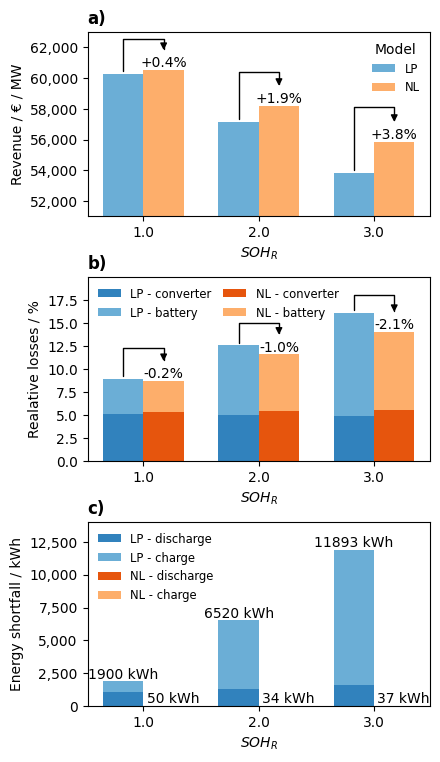

In [10]:
fig1 = plot_benchmark(df_lp0, df_nl0)

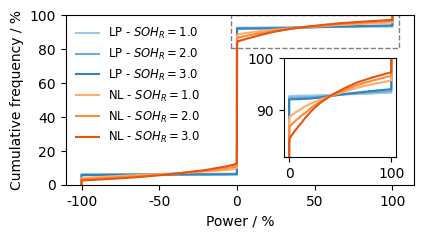

In [11]:
fig2 = plot_power_ecdf(
    res_lp = {r: res[f"2021 LP {r=} {eff=}"] for r, eff in lp_params},
    res_nl = {r: res[f"2021 NL {r=} r_opt=1.0"] for r in (1.0, 2.0, 3.0)}
)

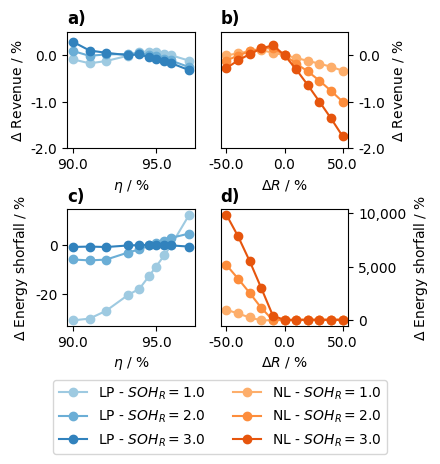

In [17]:
fig3 = plot_sensitivity(df_lp, df_nl, df_lp0, df_nl0)

In [19]:
fig1.savefig("figs/benchmark.pdf", bbox_inches="tight")
fig2.savefig("figs/power_dist.pdf", bbox_inches="tight")
fig3.savefig("figs/sensitivity.pdf", bbox_inches="tight")